# TD 6

## Identify the problem

Let's try to redo the RNN guessing the name's nationality, with the full original dataset "names" instead of "names_1000".

In [1]:
import unicodedata
import glob
import os
import torch
import torch.nn as nn
import torch.optim as optim
from unidecode import unidecode
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

c:\__APP__\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Create dataset

In [2]:
# our alphabet
LETTERS = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
N_LETTERS = len(LETTERS)

# turn a Unicode string to string of characters in our alphabet
def unicodeToAscii(s):
    return ''.join(c for c in unidecode(s) if c in LETTERS)

# turn a name into a <name_length x 1 x N_LETTERS>, or a tensor of one-hot letter vectors
def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, N_LETTERS)
    for li, letter in enumerate(name):
        tensor[li][0][LETTERS.find(letter)] = 1
    return tensor

# create a custom dataset
class NamesDataset(Dataset):
    def __init__(self, filenames='names/*.txt'):
        #read data
        self.names = []
        self.countries = []
        self.country_to_idx = {}
        self.idx_to_country = []
        for filename in glob.glob(filenames):
            country = os.path.splitext(os.path.basename(filename))[0]
            self.country_to_idx[country] = len(self.country_to_idx)
            self.idx_to_country.append(country)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for line in lines:
                self.names.append(unicodeToAscii(line))
                self.countries.append(country)
        self.n = len(self.names)
        self.n_countries = len(self.country_to_idx)
    
    def countryTensor(self, index):
        tensor = torch.zeros(1, self.n_countries)
        tensor[0][self.country_to_idx[self.countries[index]]] = 1
        return tensor

    def countryID(self, index):
        return torch.tensor(self.country_to_idx[self.countries[index]])

    def __getitem__(self, index):
        return (self.names[index], self.countries[index], \
            nameToTensor(self.names[index]), self.countryID(index))
    
    def __len__(self):
        return self.n

dataset = NamesDataset('data/names/*.txt')
# split data into train and test with random_split
train_fraction = 0.8
train_size = int(train_fraction*len(dataset))
test_size = len(dataset)-int(train_fraction*len(dataset))
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
N_COUNTRIES = dataset.n_countries

# create a dataloader
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True) # batch_size 1 as names have different lengths
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

Create the network & Train it

In [3]:
# create the network
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, idx_to_country):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.idx_to_country = idx_to_country

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def outputToCountry(self, output):
        top_n, top_i = output.topk(1)
        return self.idx_to_country[top_i[0,0].item()]

    def outputToID(self, output):
        _, top_i = output.topk(1)
        return top_i[0,0].item()

N_HIDDEN = 128
rnn = RNN(N_LETTERS, N_HIDDEN, N_COUNTRIES, dataset.idx_to_country)

# train the network
criterion = nn.NLLLoss()
lr = 0.001
optimizer = optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.NLLLoss()
n_epochs = 5
for epoch in range(n_epochs):
    loss_sum = 0
    for name, country, name_tensor, country_tensor in train_loader:
        hidden = rnn.initHidden()
        rnn.zero_grad()
        for i in range(name_tensor.size()[1]):
            output, hidden = rnn(name_tensor[0][i], hidden)
        loss = criterion(output, country_tensor[0][None])
        loss_sum += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1}/{n_epochs} ({100*(epoch+1)/n_epochs:.0f}%)\tLoss: {loss_sum:.6f}')


Epoch: 1/5 (20%)	Loss: 19061.569707
Epoch: 2/5 (40%)	Loss: 15012.768134
Epoch: 3/5 (60%)	Loss: 14157.378950
Epoch: 4/5 (80%)	Loss: 13724.080528
Epoch: 5/5 (100%)	Loss: 13451.888436


Test the network

NAME; TRUTH; PREDICTED
Guirguis; Arabic; English
Bakunin; Russian; Russian
Tchagin; Russian; Russian
Dogujiev; Russian; English
Pirin; Russian; English
Pokorny; Polish; English
Mrelashvili; Russian; English
Portyansky; Russian; English
Guzovsky; Russian; English
Moto; Japanese; English
Accuracy: 74.35%


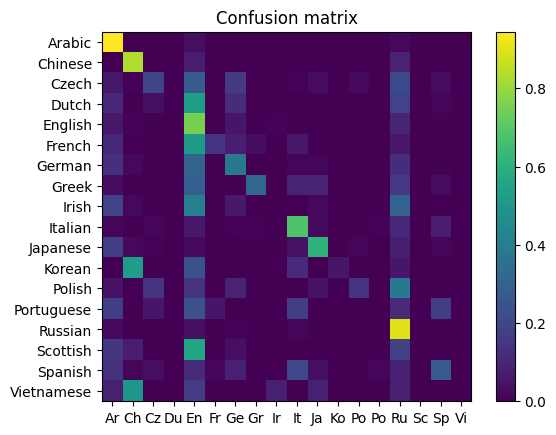

In [4]:
# test on a couple of examples
print(f'NAME; TRUTH; PREDICTED')
for i in range(10):
    name, country, name_tensor, country_tensor = test_dataset[i]
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[i], hidden)
    print(f'{name}; {country}; {rnn.outputToCountry(output)}')

# confusion matrix
confusion = torch.zeros(N_COUNTRIES, N_COUNTRIES)
accuracy = 0
for name, country, name_tensor, country_tensor in test_loader:
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[0][i], hidden)
    guess, guess_i = output.topk(1)
    category_i = country_tensor[0][None]
    confusion[category_i, guess_i] += 1
    if category_i == guess_i:
        accuracy += 1
# normalize by dividing every row by its sum
for i in range(N_COUNTRIES):
    confusion[i] = confusion[i] / confusion[i].sum()
# accuracy
print(f'Accuracy: {100*accuracy/len(test_dataset):.2f}%')

# plot confusion matrix
plt.imshow(confusion.numpy())
plt.colorbar()
plt.title('Confusion matrix')
ax = plt.gca()
positions = list(range(N_COUNTRIES))
labels = train_dataset.dataset.idx_to_country
small_labels = [label[:2] for label in labels]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(small_labels))
ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))
plt.show()

The accuracy increased! (~75% vs ~60% last time)

Let's try a couple of examples of our own:

In [5]:
names = ["Dupont", "Garcia", "Sato", "Duprès", "Suzuki", "Wang", "Santos", "Yamamoto"]
for name in names:
    name_tensor = nameToTensor(name)
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[i], hidden)
    print(f'{name}; {rnn.outputToCountry(output)}')

Dupont; English
Garcia; English
Sato; English
Duprès; English
Suzuki; English
Wang; Russian
Santos; English
Yamamoto; English


It's almost always english/russian that is predicted!

This is typical of a class unbalance, let's investigate the size of each class:

In [6]:
# cout each country in the dataset
countr_count = {}
total = 0
for country in dataset.countries:
    countr_count[country] = countr_count.get(country, 0) + 1
    total += 1
countr_count, total

({'Arabic': 2000,
  'Chinese': 268,
  'Czech': 519,
  'Dutch': 297,
  'English': 3668,
  'French': 277,
  'German': 724,
  'Greek': 203,
  'Irish': 232,
  'Italian': 709,
  'Japanese': 991,
  'Korean': 94,
  'Polish': 139,
  'Portuguese': 74,
  'Russian': 9408,
  'Scottish': 100,
  'Spanish': 298,
  'Vietnamese': 73},
 20074)

---
---
---

## Fixing the unbalanced learning

### 1st fixing idea: modify the dataset

Instead of loading names one by one, choose a country at random, then choose a name at random from this category.
Do this using an iterable dataset (checkout the doc here: https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset).

In [23]:
from torch.utils.data import IterableDataset
import random

# create a custom dataset
class NamesIterableDataset(IterableDataset):
    def __init__(self, filenames='names/*.txt'):
        #read data
        self.names = dict()
        self.country_to_idx = {}
        self.idx_to_country = []

        for filename in glob.glob(filenames):
            country = os.path.splitext(os.path.basename(filename))[0]
            self.country_to_idx[country] = len(self.country_to_idx)
            self.idx_to_country.append(country)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            self.names[country] = []
            for line in lines:
                self.names[country].append(unicodeToAscii(line))
        self.n_countries = len(self.country_to_idx)
    
    def countryTensor(self, country):
        tensor = torch.zeros(1, self.n_countries)
        tensor[0][self.country_to_idx[country]] = 1
        return tensor

    def countryID(self, country):
        return torch.tensor(self.country_to_idx[country])
    
    def __iter__(self):
        for i in range(len(self)):
            yield self.__next__()

    def __next__(self):
        # choose random country
        country = random.choice(self.idx_to_country)
        # choose random name from this country
        name = random.choice(self.names[country])
        # convert to tensors
        name_tensor = nameToTensor(name)
        countryID = self.countryID(country)
        return (name, country, name_tensor, countryID)
    
    def __len__(self):
        return 25000 # arbitrary, size of one epoch

dataset = NamesIterableDataset('data/names/*.txt')
# get a sample
name, country, name_tensor, country_tensor = next(dataset)
name, country, name_tensor.shape, country_tensor

('Hunter', 'Scottish', torch.Size([6, 1, 56]), tensor(15))

Re-define the RNN and re-train it with our new fancy iterable dataset.
Print the final accuracy, and plot the confusion matrix (which should be closer to the identity matrix).

Epoch: 1/5 (20%)	Loss: 42134.428207
Epoch: 2/5 (40%)	Loss: 33442.163606
Epoch: 3/5 (60%)	Loss: 31403.388130
Epoch: 4/5 (80%)	Loss: 30558.734499
Epoch: 5/5 (100%)	Loss: 29931.772392

NAME; TRUTH; PREDICTED
Guirguis; Arabic; German
Bakunin; Russian; Czech
Tchagin; Russian; German
Dogujiev; Russian; English
Pirin; Russian; German
Pokorny; Polish; German
Mrelashvili; Russian; German
Portyansky; Russian; German
Guzovsky; Russian; German
Moto; Japanese; German

Accuracy: 59.92%


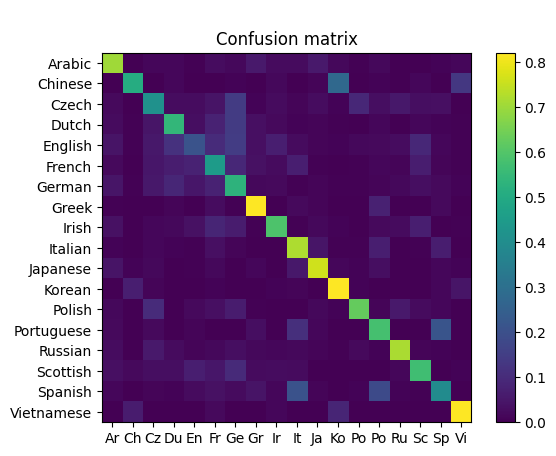

In [27]:
N_COUNTRIES = dataset.n_countries

# create a dataloader
train_loader = DataLoader(dataset, batch_size=1) # batch_size 1 as names have different lengths
test_loader = DataLoader(dataset, batch_size=1)

# create the network
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, idx_to_country):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.idx_to_country = idx_to_country

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def outputToCountry(self, output):
        top_n, top_i = output.topk(1)
        return self.idx_to_country[top_i[0,0].item()]

    def outputToID(self, output):
        _, top_i = output.topk(1)
        return top_i[0,0].item()

N_HIDDEN = 128
rnn = RNN(N_LETTERS, N_HIDDEN, N_COUNTRIES, dataset.idx_to_country)

# train the network
criterion = nn.NLLLoss()
lr = 0.001
optimizer = optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.NLLLoss()
n_epochs = 5
for epoch in range(n_epochs):
    loss_sum = 0
    for (name, country, name_tensor, country_tensor) in train_loader:
        hidden = rnn.initHidden()
        rnn.zero_grad()
        for i in range(name_tensor.size()[1]):
            output, hidden = rnn(name_tensor[0][i], hidden)
        loss = criterion(output, country_tensor[0][None])
        loss_sum += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1}/{n_epochs} ({100*(epoch+1)/n_epochs:.0f}%)\tLoss: {loss_sum:.6f}')

# test on a couple of examples
print(f'\nNAME; TRUTH; PREDICTED')
for i in range(10):
    name, country, name_tensor, country_tensor = test_dataset[i]
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[i], hidden)
    print(f'{name}; {country}; {rnn.outputToCountry(output)}')

# confusion matrix
confusion = torch.zeros(N_COUNTRIES, N_COUNTRIES)
accuracy = 0
for name, country, name_tensor, country_tensor in test_loader:
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[0][i], hidden)
    guess, guess_i = output.topk(1)
    category_i = country_tensor[0][None]
    confusion[category_i, guess_i] += 1
    if category_i == guess_i:
        accuracy += 1
# normalize by dividing every row by its sum
for i in range(N_COUNTRIES):
    confusion[i] = confusion[i] / confusion[i].sum()
# accuracy
print(f'\nAccuracy: {100*accuracy/len(test_loader):.2f}%')

# plot confusion matrix
plt.imshow(confusion.numpy())
plt.colorbar()
plt.title('\nConfusion matrix')
ax = plt.gca()
positions = list(range(N_COUNTRIES))
labels = train_dataset.dataset.idx_to_country
small_labels = [label[:2] for label in labels]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(small_labels))
ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))
plt.show()

Of course, the accuracy went down again, but at least, our RNN isn't biased.

Note that the training and testing set are the same, so the testing is less solid.

---

### 2nd fixing idea: add a sampler to the dataloader

Reuse our previous dataset, and a sampler to the dataloader.
Checkout the doc here: https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler

In [107]:
# create a custom dataset
class NamesDataset(Dataset):
    def __init__(self, filenames='names/*.txt'):
        #read data
        self.names = []
        self.countries = []
        self.country_to_idx = {}
        self.idx_to_country = []
        for filename in glob.glob(filenames):
            country = os.path.splitext(os.path.basename(filename))[0]
            self.country_to_idx[country] = len(self.country_to_idx)
            self.idx_to_country.append(country)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for line in lines:
                self.names.append(unicodeToAscii(line))
                self.countries.append(country)
        self.n = len(self.names)
        self.n_countries = len(self.country_to_idx)
    
    def countryTensor(self, index):
        tensor = torch.zeros(1, self.n_countries)
        tensor[0][self.country_to_idx[self.countries[index]]] = 1
        return tensor

    def countryID(self, index):
        return torch.tensor(self.country_to_idx[self.countries[index]])

    def __getitem__(self, index):
        return (self.names[index], self.countries[index], \
            nameToTensor(self.names[index]), self.countryID(index))
    
    def __len__(self):
        return self.n

dataset = NamesDataset('data/names/*.txt')
# split data into train and test with random_split
train_fraction = 0.8
train_size = int(train_fraction*len(dataset))
test_size = len(dataset)-int(train_fraction*len(dataset))
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
N_COUNTRIES = dataset.n_countries

# create a dataloader
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
# create a random sampler that counterbalances the classes
country_weights = torch.tensor([1/train_dataset.dataset.countries.count(country) for country in train_dataset.dataset.idx_to_country])
#train
train_items_weights = torch.tensor([country_weights[train_dataset.dataset.country_to_idx[country]] \
    for i,country in enumerate(train_dataset.dataset.countries) if i in train_dataset.indices])
train_sampler = WeightedRandomSampler(train_items_weights, len(train_dataset), replacement=True)
train_loader = DataLoader(train_dataset, sampler=train_sampler, batch_size=1)
#test
test_items_weights = torch.tensor([country_weights[test_dataset.dataset.country_to_idx[country]] \
    for i,country in enumerate(test_dataset.dataset.countries) if i in test_dataset.indices])
test_sampler = WeightedRandomSampler(test_items_weights, len(test_dataset), replacement=True)
test_loader = DataLoader(test_dataset, sampler=test_sampler, batch_size=1)

Epoch: 1/5 (20%)	Loss: 17142.809874
Epoch: 2/5 (40%)	Loss: 12797.882944
Epoch: 3/5 (60%)	Loss: 11927.091801
Epoch: 4/5 (80%)	Loss: 11514.836254
Epoch: 5/5 (100%)	Loss: 10937.804938
NAME; TRUTH; PREDICTED
Okanao; Japanese; English
Weston; English; English
Gifford; English; English
Pierno; Italian; English
Baklund; Russian; English
Yakuba; Russian; English
Kirkwood; English; English
Robins; English; English
Vedrov; Russian; English
Amelin; Russian; English
Accuracy: 70.31%


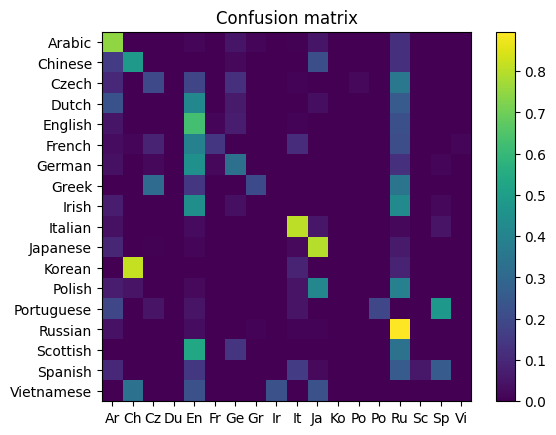

In [108]:
# create the network
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, idx_to_country):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.idx_to_country = idx_to_country

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def outputToCountry(self, output):
        top_n, top_i = output.topk(1)
        return self.idx_to_country[top_i[0,0].item()]

    def outputToID(self, output):
        _, top_i = output.topk(1)
        return top_i[0,0].item()

N_HIDDEN = 128
rnn = RNN(N_LETTERS, N_HIDDEN, N_COUNTRIES, dataset.idx_to_country)

# train the network
criterion = nn.NLLLoss()
lr = 0.001
optimizer = optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.NLLLoss()
n_epochs = 5
for epoch in range(n_epochs):
    loss_sum = 0
    for name, country, name_tensor, country_tensor in train_loader:
        hidden = rnn.initHidden()
        rnn.zero_grad()
        for i in range(name_tensor.size()[1]):
            output, hidden = rnn(name_tensor[0][i], hidden)
        loss = criterion(output, country_tensor[0][None])
        loss_sum += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1}/{n_epochs} ({100*(epoch+1)/n_epochs:.0f}%)\tLoss: {loss_sum:.6f}')

# test on a couple of examples
print(f'NAME; TRUTH; PREDICTED')
for i in range(10):
    name, country, name_tensor, country_tensor = test_dataset[i]
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[i], hidden)
    print(f'{name}; {country}; {rnn.outputToCountry(output)}')

# confusion matrix
confusion = torch.zeros(N_COUNTRIES, N_COUNTRIES)
accuracy = 0
for name, country, name_tensor, country_tensor in test_loader:
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[0][i], hidden)
    guess, guess_i = output.topk(1)
    category_i = country_tensor[0][None]
    confusion[category_i, guess_i] += 1
    if category_i == guess_i:
        accuracy += 1
# normalize by dividing every row by its sum
for i in range(N_COUNTRIES):
    confusion[i] = confusion[i] / confusion[i].sum()
# accuracy
print(f'Accuracy: {100*accuracy/len(test_dataset):.2f}%')

# plot confusion matrix
plt.imshow(confusion.numpy())
plt.colorbar()
plt.title('Confusion matrix')
ax = plt.gca()
positions = list(range(N_COUNTRIES))
labels = train_dataset.dataset.idx_to_country
small_labels = [label[:2] for label in labels]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(small_labels))
ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))
plt.show()

The accuracy is higher, but the confusion matrix is more polarized; this technique only partially compensate for the class inbalance.

---

### 3rd fixing idea: weight the loss function

Reuse our previous dataset, dataloader, but modify the loss function to compensate the class sizes.
Checkout the doc here: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss

Epoch: 1/5 (20%)	Loss: 18946.462587
Epoch: 2/5 (40%)	Loss: 14849.718004
Epoch: 3/5 (60%)	Loss: 14104.564540
Epoch: 4/5 (80%)	Loss: 13639.007837
Epoch: 5/5 (100%)	Loss: 13379.365059
NAME; TRUTH; PREDICTED
Kipling; English; English
Nyrko; Russian; English
Tracey; Irish; English
Minovalov; Russian; English
Habichev; Russian; English
Alkov; Russian; English
Bonfils; French; English
Dahnov; Russian; English
Bear; English; English
ODowd; Irish; English
Accuracy: 73.55%


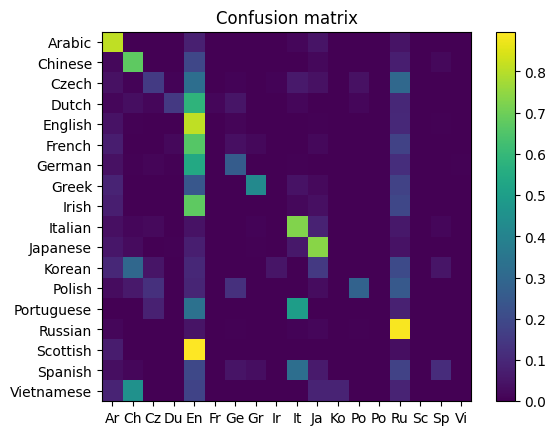

In [109]:
# create a custom dataset
class NamesDataset(Dataset):
    def __init__(self, filenames='names/*.txt'):
        #read data
        self.names = []
        self.countries = []
        self.country_to_idx = {}
        self.idx_to_country = []
        for filename in glob.glob(filenames):
            country = os.path.splitext(os.path.basename(filename))[0]
            self.country_to_idx[country] = len(self.country_to_idx)
            self.idx_to_country.append(country)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for line in lines:
                self.names.append(unicodeToAscii(line))
                self.countries.append(country)
        self.n = len(self.names)
        self.n_countries = len(self.country_to_idx)
    
    def countryTensor(self, index):
        tensor = torch.zeros(1, self.n_countries)
        tensor[0][self.country_to_idx[self.countries[index]]] = 1
        return tensor

    def countryID(self, index):
        return torch.tensor(self.country_to_idx[self.countries[index]])

    def __getitem__(self, index):
        return (self.names[index], self.countries[index], \
            nameToTensor(self.names[index]), self.countryID(index))
    
    def __len__(self):
        return self.n

dataset = NamesDataset('data/names/*.txt')
# split data into train and test with random_split
train_fraction = 0.8
train_size = int(train_fraction*len(dataset))
test_size = len(dataset)-int(train_fraction*len(dataset))
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
N_COUNTRIES = dataset.n_countries

# create a dataloader
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True) # batch_size 1 as names have different lengths
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# create the network
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, idx_to_country):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.idx_to_country = idx_to_country

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def outputToCountry(self, output):
        top_n, top_i = output.topk(1)
        return self.idx_to_country[top_i[0,0].item()]

    def outputToID(self, output):
        _, top_i = output.topk(1)
        return top_i[0,0].item()

N_HIDDEN = 128
rnn = RNN(N_LETTERS, N_HIDDEN, N_COUNTRIES, dataset.idx_to_country)

# train the network
criterion = nn.NLLLoss()
lr = 0.001
optimizer = optim.Adam(rnn.parameters(), lr=lr)
country_weights = torch.tensor([1/train_dataset.dataset.countries.count(country) for country in train_dataset.dataset.idx_to_country])
criterion = nn.NLLLoss(country_weights)
n_epochs = 5
for epoch in range(n_epochs):
    loss_sum = 0
    for name, country, name_tensor, country_tensor in train_loader:
        hidden = rnn.initHidden()
        rnn.zero_grad()
        for i in range(name_tensor.size()[1]):
            output, hidden = rnn(name_tensor[0][i], hidden)
        loss = criterion(output, country_tensor[0][None])
        loss_sum += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1}/{n_epochs} ({100*(epoch+1)/n_epochs:.0f}%)\tLoss: {loss_sum:.6f}')

# test on a couple of examples
print(f'NAME; TRUTH; PREDICTED')
for i in range(10):
    name, country, name_tensor, country_tensor = test_dataset[i]
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[i], hidden)
    print(f'{name}; {country}; {rnn.outputToCountry(output)}')

# confusion matrix
confusion = torch.zeros(N_COUNTRIES, N_COUNTRIES)
accuracy = 0
for name, country, name_tensor, country_tensor in test_loader:
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[0][i], hidden)
    guess, guess_i = output.topk(1)
    category_i = country_tensor[0][None]
    confusion[category_i, guess_i] += 1
    if category_i == guess_i:
        accuracy += 1
# normalize by dividing every row by its sum
for i in range(N_COUNTRIES):
    confusion[i] = confusion[i] / confusion[i].sum()
# accuracy
print(f'Accuracy: {100*accuracy/len(test_dataset):.2f}%')

# plot confusion matrix
plt.imshow(confusion.numpy())
plt.colorbar()
plt.title('Confusion matrix')
ax = plt.gca()
positions = list(range(N_COUNTRIES))
labels = train_dataset.dataset.idx_to_country
small_labels = [label[:2] for label in labels]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(small_labels))
ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))
plt.show()